In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
import datetime
import os
from Imputer.knn_imputer import KNNImputer
import pdb
imagedir = 'images'
if not os.path.isdir(imagedir):
    os.mkdir(imagedir)
# For numeric stability
EPSILON = 1e-10

df = pd.read_csv(
    'houselistings_simulated.csv', parse_dates=['ListingDate', 'SalesDate'])

dataset_end = df['SalesDate'].max()

FIRST_CUTOFF = pd.to_datetime('2017-02-01')
LAST_CUTOFF = df['SalesDate'].max() - pd.DateOffset(months=1)


def split_at(df, start_date=None, end_date=None):
    data_idx = np.ones(df.shape[0], dtype=bool)
    if start_date is not None:
        data_idx = data_idx & (df.SalesDate >= start_date)
    if end_date is not None:
        data_idx = data_idx & (df.ListingDate < end_date)
    return df.loc[data_idx, :].copy()


def scale(df, scaling_mean=None, scaling_std=None):
    numeric_features_train = df.select_dtypes(include=[np.number]).copy()
    if scaling_mean is None:
        scaling_mean, scaling_std = numeric_features_train.mean(
        ), numeric_features_train.std()
    numeric_features_train = (
        numeric_features_train - scaling_mean) / scaling_std
    return numeric_features_train, scaling_mean, scaling_std


def build_imputer(numeric_features_train):
    imputer = KNNImputer()
    imputer.fit(numeric_features_train)
    return imputer


def apply_imputer(imputer, features):
    features = features.copy()
    imputer.fill_in(features)
    return features


def build_Y(df, end):
    sold = df['SalesDate'] < end
    Y = df['SalesDate'].clip(upper=end).fillna(end) - df['ListingDate']
    return sold, Y.dt.days.astype(float)


class Model():
    def __init__(self, input_size, layer_sizes):
        self.input_size = input_size
        self.layer_sizes = layer_sizes

        self.sold = tf.placeholder(tf.float32, shape=(None))
        self.x = tf.placeholder(tf.float32, shape=(None, input_size))
        self.y = tf.placeholder(tf.float32, shape=(None))

        self.layers = [self.x]
        for layer_size in layer_sizes:
            next_layer = tf.nn.leaky_relu(
                tf.layers.dense(self.layers[-1], layer_size))
            self.layers.append(next_layer)

        self.output = tf.nn.softplus(tf.layers.dense(self.layers[-1], 1))

        self.loss_indicator = (tf.cast(self.output < self.y, tf.float32) *
                               (1 - self.sold) + self.sold)

        def build_loss(loss, loss_indicator):
            loss_numerator = tf.reduce_sum(loss * self.loss_indicator)
            loss_denominator = (tf.reduce_sum(self.loss_indicator)) + EPSILON
            return loss_numerator / loss_denominator

        RMSLE_raw = tf.sqrt(
            tf.reduce_mean(
                tf.square(
                    tf.log((self.output + EPSILON) / (self.y + EPSILON)))))
        self.RMSLE = build_loss(RMSLE_raw, self.loss_indicator)
        MAPE_raw = tf.reduce_mean(
            tf.abs(tf.log((self.output + EPSILON) / (self.y + EPSILON))))
        self.MAPE = build_loss(MAPE_raw, self.loss_indicator)

        self.optimizer = tf.train.AdamOptimizer().minimize(self.RMSLE)

        self.sess = tf.Session()
        self.sess.run(tf.global_variables_initializer())

        self.trn_losses = []
        self.val_losses = []
        self.r2_scores = []

    def train_one_epoch(self, X_train, Y_train, sold_train, bs):
        # Train an epoch
        trn_loss = []
        # Randomly shuffle data and prepare for training
        trn_samples = X_train.shape[0]
        order = np.arange(trn_samples)
        np.random.shuffle(order)
        num_batches = (trn_samples // bs) + 1
        for itr in range(trn_samples // bs):
            rows = order[itr * bs:(itr + 1) * bs]
            if itr + 1 == num_batches:
                rows = order[itr * bs:]
            X_active, Y_active, Sold_active = [
                mat[rows] for mat in [X_train, Y_train, sold_train]
            ]
            feed_dict = {
                self.x: X_active,
                self.y: Y_active,
                self.sold: Sold_active
            }
            _, loss = self.sess.run([self.optimizer, self.RMSLE], feed_dict)
            trn_loss.append(loss)
        self.trn_losses.append(np.mean(trn_loss))

    def validate(self, X_test, Y_test, sold_test):
        feed_dict = {self.x: X_test, self.y: Y_test, self.sold: sold_test}
        val_loss, yhat = self.sess.run([self.RMSLE, self.output], feed_dict)
        self.val_losses.append(val_loss)
        self.r2_scores.append(r2_score(Y_test, yhat))

    def train(self, Xtrn, Xval, Ytrn, Yval, Soldtrn, Soldval, epochs, bs=64):
        # Everything is set. Now train and validate
        for epoch in range(epochs):
            # run one epoch train and validation
            self.train_one_epoch(Xtrn, Ytrn, Soldtrn, bs)
            self.validate(Xval, Yval, Soldval)

            if (epoch % 10 == 0) or (epoch == epochs-1):
                # Occasionally print to command line to inspect performance
                print('epoch:', epoch, 'train loss: ', self.trn_losses[-1],
                      'val loss: ', self.val_losses[-1], 'r2_score:',
                      self.r2_scores[-1])

    def visualize(self, name):
        # Visualize training and validation losses and r2 scores on one plot
        _, ax1 = plt.subplots()
        ax2 = ax1.twinx()
        ax1.plot(self.trn_losses, label='train loss')
        ax1.plot(self.val_losses, label='test loss')
        ax2.plot(self.r2_scores, label='validation r2_scores', color='g')
        ax1.set_xlabel('epochs')
        ax1.set_ylabel('least square losses')
        ax2.set_ylabel('R2 Scores')
        ax2.legend()
        ax1.legend()
        plt.title('Losses and r2 scores for ' + name)
        plt.savefig(imagedir + '/' + name + '.jpg')
        plt.show()
        plt.show()

def trn_validate(df, trn_end, val_end, layer_sizes):
    df_train = split_at(df, end_date=trn_end)
    df_val = split_at(df, start_date=trn_end, end_date=val_end)

    numeric_features_train, scaling_mean, scaling_std = scale(df_train)
    numeric_features_val, _, _ = scale(df_val, scaling_mean, scaling_std)
    nan_trn = numeric_features_train.isnull()
    nan_val = numeric_features_val.isnull()
    imputer = build_imputer(numeric_features_train)
    
    trn_imputed = apply_imputer(imputer, numeric_features_train)
    val_imputed = apply_imputer(imputer, numeric_features_val)

    trn_imputed = pd.concat((trn_imputed, nan_trn.astype(float)), 1)
    val_imputed = pd.concat((val_imputed, nan_val.astype(float)), 1)

    trn_sold, trn_Y = build_Y(df_train, trn_end)

    val_sold, val_Y = build_Y(df_val, dataset_end)

    n_features = trn_imputed.shape[1]

    model = Model(n_features, layer_sizes=layer_sizes)
    model.train(
        trn_imputed.values,
        val_imputed.values,
        trn_Y.values,
        val_Y.values,
        trn_sold.values,
        val_sold.values,
        epochs=10)
    model.visualize('Loss and r2_scores ' + str(trn_end) + ' to \n' + 
                    str(val_end) + ' layers: ' + str(layer_sizes))
    return model.val_losses[-1]

def walkforward_optimization(df, FIRST_CUTOFF, LAST_CUTOFF):
    trn_end = FIRST_CUTOFF
    val_end = FIRST_CUTOFF + pd.DateOffset(months = 1)
    # FIRST_CUTOFF = pd.to_datetime('2017-01-01')
    # LAST_CUTOFF = df['SalesDate'].max() - pd.DateOffset(months=1)
    validation_losses = pd.DataFrame()
    idx = 0
    while val_end <= LAST_CUTOFF:
        idx += 1
        validation_loss = trn_validate(df, trn_end, val_end, [100])
        validation_losses.loc[idx, 'cutoffs'] = val_end
        validation_losses.loc[idx, 'losses'] = validation_loss
        trn_end = trn_end + pd.DateOffset(months=1)
        val_end = val_end + pd.DateOffset(months=1)
    return validation_losses

/home/lee/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
def visualize_walkforward_optimization_performance(validation_losses):
    plt.plot(validation_losses['cutoffs'], validation_losses['losses'])
    plt.xticks(rotation=-60)
    plt.legend()
    plt.xlabel('cutoff time')
    plt.ylabel('validation loss')
    plt.title('losses throughout walkforward optimization')
    plt.show()

epoch: 0 train loss:  2.0508163 val loss:  0.94038236 r2_score: -5.118137180908715
epoch: 9 train loss:  0.606942 val loss:  0.33460137 r2_score: -0.5321314055742814


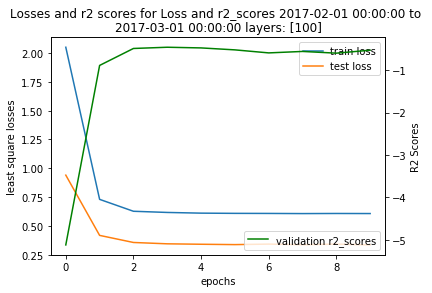

epoch: 0 train loss:  2.0228112 val loss:  0.9140986 r2_score: -4.959761565219368
epoch: 9 train loss:  0.5982416 val loss:  0.32213718 r2_score: -0.43283701162949373


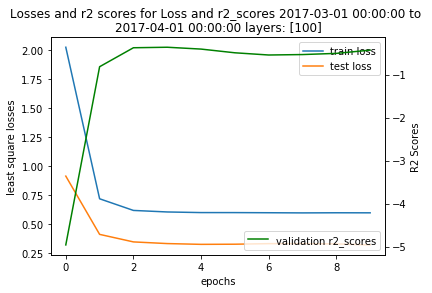

epoch: 0 train loss:  1.9948672 val loss:  0.88431513 r2_score: -4.711516222069413
epoch: 9 train loss:  0.58925366 val loss:  0.3260477 r2_score: -0.4815805084050928


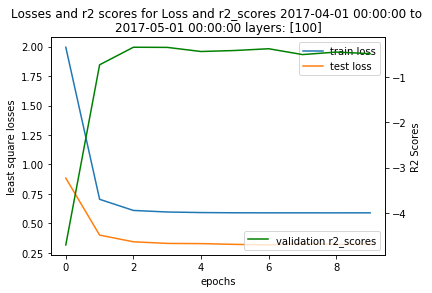

epoch: 0 train loss:  1.9356432 val loss:  0.80944836 r2_score: -4.106830378204859
epoch: 9 train loss:  0.578031 val loss:  0.32024986 r2_score: -0.43642776926865134


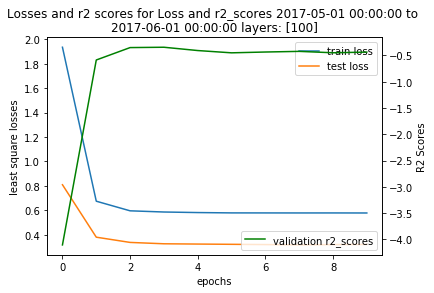

epoch: 0 train loss:  1.8917559 val loss:  0.77459276 r2_score: -4.066014811291876
epoch: 9 train loss:  0.56999624 val loss:  0.31652784 r2_score: -0.46607213025434024


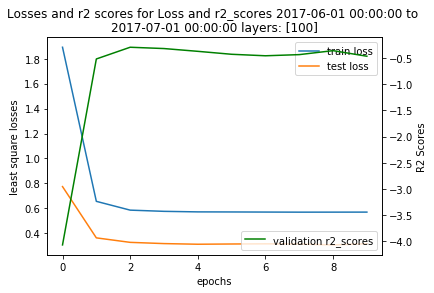

epoch: 0 train loss:  1.880859 val loss:  0.71966565 r2_score: -3.5873680710825537
epoch: 9 train loss:  0.5612318 val loss:  0.30603045 r2_score: -0.3761240744568828


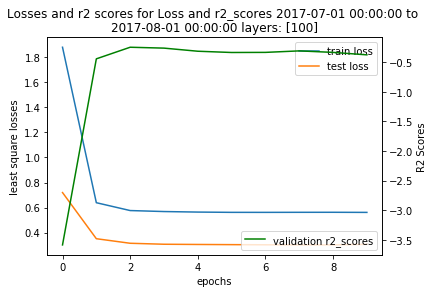

epoch: 0 train loss:  1.873664 val loss:  0.70320153 r2_score: -3.4048601930719196
epoch: 9 train loss:  0.56358343 val loss:  0.2991331 r2_score: -0.2880849615847796


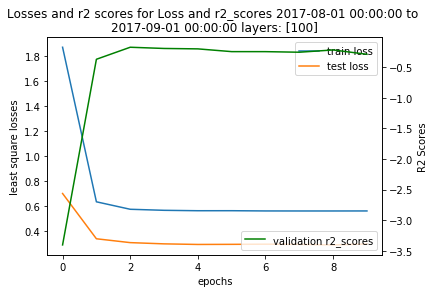

epoch: 0 train loss:  1.8543288 val loss:  0.69244975 r2_score: -2.9529889077839995
epoch: 9 train loss:  0.5626842 val loss:  0.29812518 r2_score: -0.11996487408066359


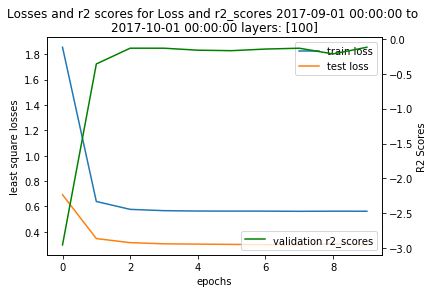

epoch: 0 train loss:  1.7614454 val loss:  0.5833321 r2_score: -2.0136800772110166
epoch: 9 train loss:  0.5466773 val loss:  0.30615276 r2_score: -0.11397831136632042


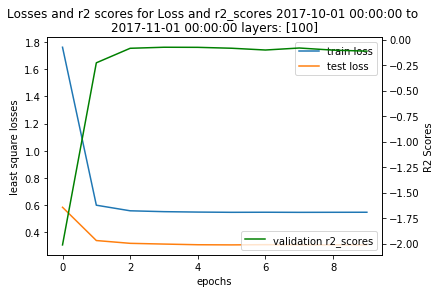

epoch: 0 train loss:  1.8028965 val loss:  0.61670697 r2_score: -2.2736702324014666
epoch: 9 train loss:  0.54028255 val loss:  0.30904034 r2_score: -0.09481240248814404


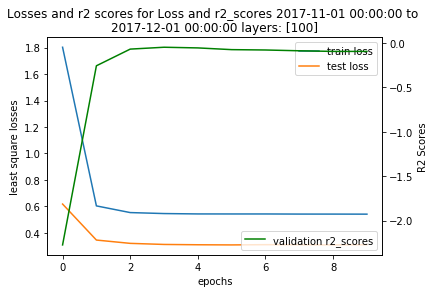

,cutoffs,losses
1,2017-03-01,0.334601
2,2017-04-01,0.322137
3,2017-05-01,0.326048
4,2017-06-01,0.320250
5,2017-07-01,0.316528
6,2017-08-01,0.306030
7,2017-09-01,0.299133
8,2017-10-01,0.298125
9,2017-11-01,0.306153
10,2017-12-01,0.309040


In [3]:
walkforward_optimization(df, FIRST_CUTOFF, LAST_CUTOFF)

In [4]:
visualize_walkforward_optimization_performance(validation_losses)

NameError: name 'validation_losses' is not defined